# Fine-tuning a pre-trained Convolutional Network

A practical approach to training a convolutional network is to fine-tune an existing pretrained convolutional network. This works well in cases where there is reasonable overlap between the classification tasks of the pre-trained network and the new classification task.

We will show how to fine-tune an existing network trained on the imagenet classification task, to instead classify the "styles" of flickr images, from a Flickr style dataset. The dataset is already available on the Amazon EC2 instance, but if you're running this code from elsewhere, the dataset can easily be downloaded with scripts bundled with caffe:
```
scripts/download_model_binary.py models/bvlc_reference_caffenet
python examples/finetune_flickr_style/assemble_data.py --workers=-1 --images=2000 --seed=1701 --label=5
```
Note that we only train the classifier on a small portion of the dataset as an example, using only 2000 images and five of the labels. The dataset consists of photos from flickr classified according to certain styles:
![](./images/finetuning_example.png)

In [1]:
caffe_root = '/home/ubuntu/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import os
os.chdir('../caffe')

import caffe
import numpy as np
from pylab import *
%matplotlib inline

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/ubuntu/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


Let's show what is the difference between the fine-tuning network and the original caffe model.

![](./images/finetuning_mod2.png)

In [2]:
niter = 400
test_interval = 25
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
scratch_train_loss = np.zeros(niter)
scratch_test_acc = zeros(int(np.ceil(niter / test_interval)))

caffe.set_device(0)
caffe.set_mode_gpu()
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')
solver.net.copy_from('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# For reference, we also create a solver that does no finetuning.
scratch_solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')

# We run the solver for niter times, and record the training loss and accuracy.
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    scratch_solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=%f' % (it, train_loss[it], scratch_train_loss[it])
        #print 'iter %d, finetune_loss=%f' % (it, train_loss[it])
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        scratch_correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['fc8_flickr'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            scratch_solver.test_nets[0].forward()
            scratch_correct += sum(scratch_solver.test_nets[0].blobs['fc8_flickr'].data.argmax(1)
                           == scratch_solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 5000.
        scratch_test_acc[it // test_interval] = scratch_correct / 5000.
print 'done'

iter 0, finetune_loss=3.952933, scratch_loss=2.760101
Iteration 0 testing...
iter 10, finetune_loss=3.237772, scratch_loss=13.024966
iter 20, finetune_loss=1.523035, scratch_loss=2.794031
Iteration 25 testing...
iter 30, finetune_loss=1.394668, scratch_loss=1.883649
iter 40, finetune_loss=1.378715, scratch_loss=2.066198
iter 50, finetune_loss=1.863082, scratch_loss=1.929131
Iteration 50 testing...
iter 60, finetune_loss=1.578399, scratch_loss=1.844611
iter 70, finetune_loss=1.428069, scratch_loss=2.050955
Iteration 75 testing...
iter 80, finetune_loss=1.174107, scratch_loss=1.559927
iter 90, finetune_loss=1.355443, scratch_loss=1.807613
iter 100, finetune_loss=0.984699, scratch_loss=1.622659
Iteration 100 testing...
iter 110, finetune_loss=1.353656, scratch_loss=1.851854
iter 120, finetune_loss=0.931875, scratch_loss=1.743329
Iteration 125 testing...
iter 130, finetune_loss=0.907308, scratch_loss=1.667125
iter 140, finetune_loss=1.134032, scratch_loss=1.701541
iter 150, finetune_loss=0

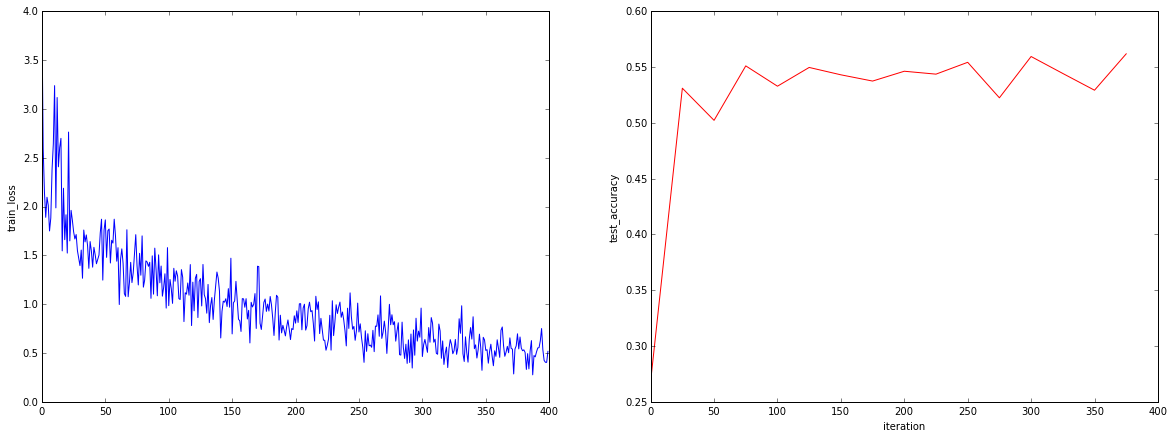

In [4]:
# plot training loss and accuracy for finetuned model
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')

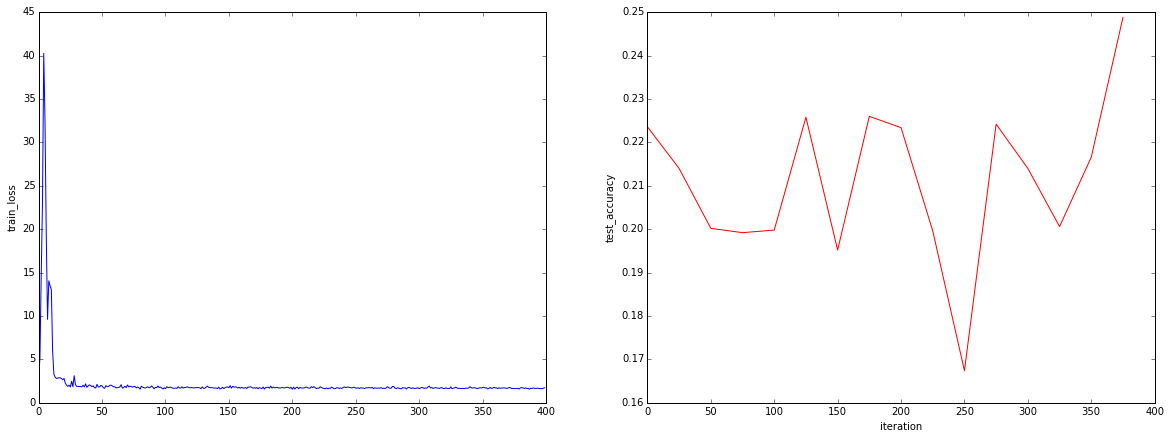

In [5]:
# plot training loss and accuracy for model trained from scratch
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), scratch_train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(scratch_test_acc)), scratch_test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')